In [1]:
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

In [3]:
def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

In [4]:
def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

In [5]:
def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

In [6]:
def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

In [7]:
def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

In [8]:
def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

In [49]:
def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(r2_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(r2_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('Model Hasil/Linear_AD.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

In [50]:
# Load Data Train csv
train = pickle.load(open('Train_Test/train_bams.p','rb'))
test = pickle.load(open('Train_Test/test_bams.p','rb'))
train.shape, test.shape

((107, 1876), (27, 1876))

# SVR_RBF

In [11]:
# Load Pickle rbf
params = pickle.load(open("data_RBF/new_params_rbf_25.p", "rb"))

label = pickle.load(open("desc/new_desc25.pkl", "rb"))
x_train = train.loc[:,label].to_numpy()
x_test = test.loc[:,label].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax rbf
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'rbf', C = params['C'],
           gamma = params['gamma'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
train_rbf = q2_loo(model, sc_x_train, y_train)
train_rbf

(array([0.7941842]),
 [7.398084497837602,
  5.259968414893728,
  6.34805292925164,
  6.89341010025595,
  5.475625227626438,
  8.527715978765162,
  6.982011001076818,
  8.282775693050118,
  5.618759259828908,
  6.568486893145541,
  6.808740703351881,
  6.78689312002403,
  8.048941972968302,
  6.32748877636439,
  8.12074636067092,
  5.5596877404214915,
  6.919657401563091,
  5.555591678785804,
  5.718691206691142,
  8.736658759712045,
  7.850429148930996,
  8.289823887449252,
  7.622717712906105,
  7.206535077410946,
  8.487247656484401,
  6.381036219100004,
  5.816396996814203,
  6.307669316256572,
  7.466933762599037,
  6.851520650353572,
  6.168704147550906,
  5.622708096037996,
  5.641177706326095,
  5.233834969406077,
  6.453266219845795,
  5.8786332120885065,
  6.347902896841859,
  6.262728450241636,
  6.478407385837004,
  5.5156488483060295,
  5.575985611364363,
  5.437542760755849,
  7.129420453254516,
  5.764941452872211,
  6.128796939527391,
  6.0627274455062405,
  5.2604943138

In [13]:
train_rbf_r2 = r2_score(y_train, train_rbf[1])
train_rbf_r2

array([0.7941842])

In [14]:
y_test.shape, len(model.predict(x_test))

((27, 1), 27)

In [15]:
test_pred = model.predict(sc_x_test)
test_pred

array([5.67010008, 5.34031858, 5.75637307, 6.26822256, 7.64973106,
       7.11259094, 8.23598107, 5.70858136, 6.9112195 , 5.55925543,
       5.52045322, 8.33935275, 8.65710657, 6.78116755, 5.53524473,
       5.46733734, 8.79118111, 5.41848235, 6.62778577, 7.65223373,
       6.64019301, 8.51946891, 7.0406698 , 7.0566492 , 8.53438072,
       8.34951223, 5.73940516])

In [16]:
rbf_qsar = qsar_param(y_train, train_rbf[1], d_r2m=True)
pd.DataFrame(rbf_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.794547,0.961154,0.972488,0.008427,0.012408,0.003164,0.722593,0.013879


In [17]:
rbf_qsar = qsar_param(y_test, test_pred, d_r2m=True)
pd.DataFrame(rbf_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.85811,1.036394,0.911114,0.050077,0.005964,0.037855,0.738475,0.116498


In [18]:
rbf_y = y_random(model, sc_x_train, y_train, n=10)
rbf_y

array([0.65159521])

0.7289719626168224


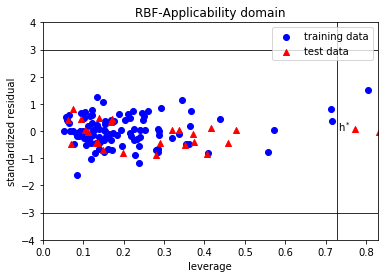

In [21]:
plt.title('RBF-Applicability domain')
rbf_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_rbf[1], y_test, test_pred)
rbf_AD

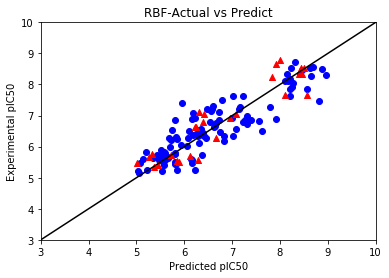

In [22]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_rbf[1], c='b',marker='o', label='training data')
ax.scatter(y_test, test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('RBF-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('Model Hasil/RBF_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

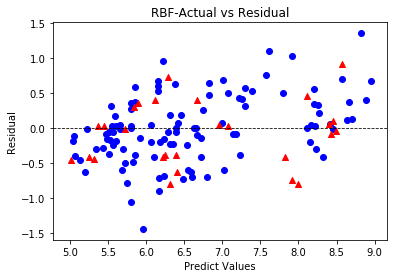

In [23]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_rbf[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(test_pred).to_numpy()

train = r_train-r_train_pred
test = r_test-r_test_pred
plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, train, c='b',marker='o', label='training data')
plt.scatter(r_test, test, c='r',marker='^', label='test data')
plt.title("RBF-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('Model Hasil/RBF_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Poly

In [26]:
# Load Pickle poly
params = pickle.load(open("data_Poly/new_params_poly_25.p", "rb"))

poly = pickle.load(open("desc/new_desc25.pkl", "rb"))
x_train = train.loc[:,poly].to_numpy()
x_test = test.loc[:,poly].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax poly
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'poly', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
train_q2_poly = q2_loo(model, sc_x_train, y_train)
train_q2_poly

(array([0.7291073]),
 [7.37901044947423,
  5.473353329336453,
  6.486413413862235,
  6.793385201342336,
  5.586278619733944,
  8.291969229015672,
  6.910556549399923,
  7.941641055827442,
  5.631322089172374,
  6.64483013232414,
  6.804629673342732,
  6.807397411289825,
  7.544447602214162,
  6.149423523785559,
  9.725022337060167,
  5.734653362580772,
  6.84350121250101,
  5.928852260306954,
  5.624312571121967,
  9.751768951144737,
  7.534600523481884,
  8.204201088762513,
  7.632437093077165,
  7.16428227970702,
  9.175061329816176,
  6.379353513414175,
  5.794425303412689,
  6.418778334042717,
  8.46805699069732,
  6.786226222466804,
  6.252390875008402,
  5.584509111708876,
  5.8886555366640785,
  5.439944847641842,
  6.241144857006485,
  6.092601707556047,
  6.384556529137349,
  6.263645064168882,
  6.5312744474505955,
  5.537492105129013,
  5.670083182541998,
  5.722266871927156,
  8.246900749549502,
  5.805960072394923,
  6.225309276743193,
  5.966028944964539,
  5.431169442849

In [28]:
poly = r2_score(y_train, train_q2_poly[1])
poly

array([0.7291073])

In [29]:
poly_test_pred = model.predict(sc_x_test)
poly_test_pred

array([5.87842884, 5.51424079, 5.70344571, 6.14555362, 8.88978608,
       7.02876292, 8.66046873, 5.62200408, 6.99356956, 5.6184576 ,
       5.69210097, 8.9192894 , 8.93879604, 6.6941391 , 5.92195199,
       5.79322731, 9.54995768, 5.4049546 , 6.37328818, 7.61893931,
       6.61874919, 8.05602033, 7.08879204, 6.54303394, 8.67955127,
       7.70418352, 5.66958032])

In [30]:
poly_qsar = qsar_param(y_train, train_q2_poly[1], d_r2m=True)
pd.DataFrame(poly_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.754699,1.168911,0.778753,0.061202,0.000084,0.046126,0.670598,0.156192


In [31]:
poly_qsar = qsar_param(y_test, poly_test_pred, d_r2m=True)
pd.DataFrame(poly_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.808956,1.176018,0.780596,0.100123,0.010843,0.072224,0.655962,0.154463


In [32]:
poly_y = y_random(model, sc_x_train, y_train, n=10)
poly_y

array([0.7336643])

0.7289719626168224


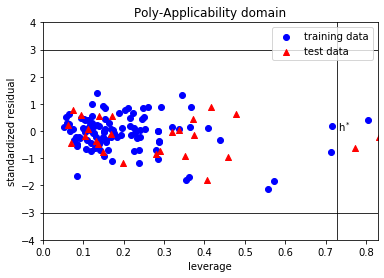

In [36]:
plt.title('Poly-Applicability domain')
poly_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_poly[1], y_test, poly_test_pred)
poly_AD

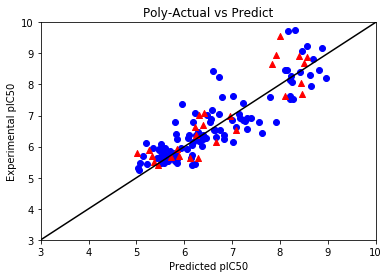

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_poly[1], c='b',marker='o', label='training data')
ax.scatter(y_test, poly_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Poly-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('Model Hasil/poly_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

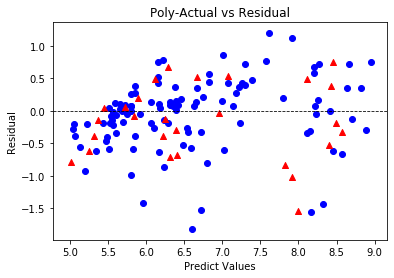

In [38]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_poly[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(poly_test_pred).to_numpy()

p_train = r_train-r_train_pred
p_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, p_train, c='b',marker='o', label='training data')
plt.scatter(r_test, p_test, c='r',marker='^', label='test data')
plt.title("Poly-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('Model Hasil/Poly_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Linear

In [41]:
# Load Pickle linear
params = pickle.load(open("data_Linear/new_params_linear_25.p", "rb"))

linear = pickle.load(open("desc/new_desc25.pkl", "rb"))
x_train = train.loc[:,linear].to_numpy()
x_test = test.loc[:,linear].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax linear
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'linear', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
train_q2_linear = q2_loo(model, sc_x_train, y_train)
train_q2_linear

(array([0.61829401]),
 [7.371715297256414,
  5.242209105035011,
  6.3171998330204815,
  7.044901404499375,
  5.854795295645355,
  8.256159455170055,
  6.365925754289189,
  7.80806964209766,
  5.987508410786464,
  7.0153623764512805,
  6.787566682376442,
  6.862223739943291,
  7.364345849421651,
  5.5322984623815366,
  8.216555890434817,
  5.583328144003645,
  7.072405599534985,
  6.341542680203716,
  6.004300836046973,
  8.43536273588302,
  7.381427361556183,
  8.043096485939413,
  7.115652677947889,
  6.609133136593282,
  7.801087981521299,
  6.253033634590622,
  5.9734953627266165,
  7.246293985303312,
  7.522568854817077,
  6.529345335534238,
  6.169628708338442,
  5.9240473182286895,
  5.88598880692766,
  5.686924866409644,
  6.0635226755200256,
  6.509728520152441,
  6.271314184359649,
  6.2727902599129,
  6.439539238189482,
  5.532438158340797,
  5.744905533133158,
  5.933586712122841,
  8.729856134495133,
  5.416105017754795,
  6.456100990722364,
  5.966091507753614,
  5.8175105

In [43]:
linear = r2_score(y_train, train_q2_linear[1])
linear

array([0.61829401])

In [44]:
linear_test_pred = model.predict(sc_x_test)
linear_test_pred

array([5.57117434, 5.48168893, 5.87284414, 5.93977894, 7.89893135,
       7.04292435, 8.63479361, 5.57689655, 8.62804526, 5.41521077,
       5.77030343, 9.05371818, 8.13641898, 6.69843208, 6.33495609,
       5.80211777, 8.11598814, 5.78122927, 6.19949678, 7.24402801,
       6.65609353, 7.70635133, 6.60583014, 6.83063031, 8.75347206,
       8.35556735, 5.69051221])

In [45]:
linear_qsar = qsar_param(y_train, train_q2_linear[1], d_r2m=True)
pd.DataFrame(linear_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.622703,1.28601,0.681312,0.040242,0.060493,0.01261,0.512987,0.022283


In [46]:
linear_qsar = qsar_param(y_test, linear_test_pred, d_r2m=True)
pd.DataFrame(linear_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.760963,1.092204,0.829968,0.093503,0.002136,0.069527,0.644132,0.172303


In [47]:
linear_y = y_random(model, sc_x_train, y_train, n=10)
linear_y

array([0.67513495])

0.7289719626168224


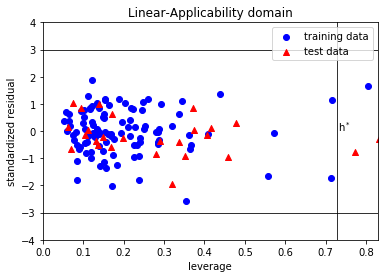

In [51]:
plt.title('Linear-Applicability domain')
linear_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_linear[1], y_test, linear_test_pred)
linear_AD

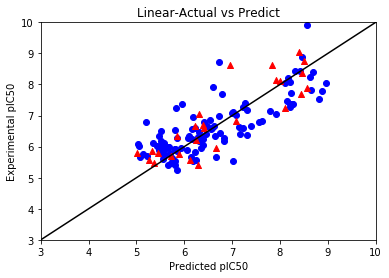

In [52]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_linear[1], c='b',marker='o', label='training data')
ax.scatter(y_test, linear_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Linear-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('Model Hasil/Linear_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

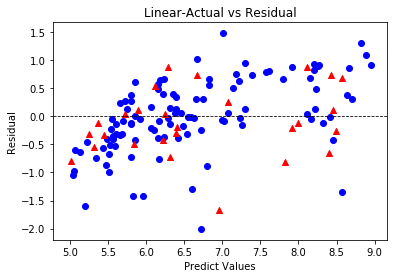

In [53]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_linear[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(linear_test_pred).to_numpy()

l_train = r_train-r_train_pred
l_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, l_train, c='b',marker='o', label='training data')
plt.scatter(r_test, l_test, c='r',marker='^', label='test data')
plt.title("Linear-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('Model Hasil/Linear_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")